### Finetuning Gemma Model 3 for a Language Task
In this notebook we demonstrate how to build a Finetune model using NVIDIA A100 GPUs. We will use the GPU during inference. The approach will be based on [Parameter Efficient Fine Tuning (peft)](https://github.com/huggingface/peft). It is a translation to help translate English to the Yoruba Language

<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; Setup <code>install the first set of libraries</code>. <b>To Access Gemma Model on Hugging Face files</b>: 1) click on the Hugging Face and create an account and then 2) click on "Profile" then follow the steps to generate an API key 3) <code> pip install -U "huggingface_hub[cli]"</code> and Set the Token.</p>



<p> ⬇ &nbsp; <b>Training:</b> 1) Step <em>"4-10"</em> are the training steps which should only be performed once then 2) Run <em>Steps 2,3,4(library & configs)</em> except <em> before doing your inference if you restart the kernel</em>.</p>

<p> 📒 &nbsp; Production, You can host the model on GPU powered Serverless Compute <em>"or publicly on hugging face"</em>.</p>

<p> <b>The first section is OPTIONAL but designed to get you familiar with Large Language Model (LLM) training in general </b></p>

<p>Additional Resources & Credit: MIT - https://introtodeeplearning.com</p>
</div>

In [1]:
# Uncomment to run - requires python.311 - Setup with Conda
# from platform import python_version
# print(python_version())
# Install all the libraries - Uncomment to run
# !pip install datasets
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124 --no-cache-dir --verbose
# !pip uninstall flash-attn --y
# !pip install transformers
# !pip install bitsandbytes
# !pip install accelerate
# !pip install peft
# !pip install trl
# !pip install matplotlib
# !pip install wandb
# !pip install lion_pytorch
# !pip install ipywidgets
# !git config --global credential.helper store

In [2]:
import os
import json
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader
torch.set_float32_matmul_precision('high')

from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, BitsAndBytesConfig, pipeline
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from lion_pytorch import Lion
from datasets import load_dataset, Dataset

In [3]:
#hugging Face setup - - Uncomment to run
# from huggingface_hub import notebook_login

# notebook_login()

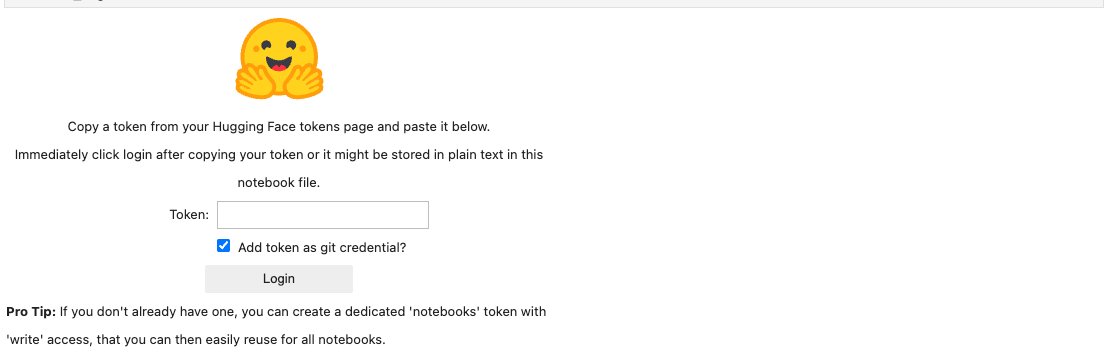

In [4]:
# Basic question-answer template
template_without_answer = "<start_of_turn>user\n{question}<end_of_turn>\n<start_of_turn>model\n"
template_with_answer = template_without_answer + "{answer}<end_of_turn>\n"

# Let's try to put something into the template to see how it looks
print(template_with_answer.format(question="What is your name?", answer="My name is Gemma!"))

<start_of_turn>user
What is your name?<end_of_turn>
<start_of_turn>model
My name is Gemma!<end_of_turn>



In [5]:
# Load the tokenizer for Gemma 2B
model_id = "google/gemma-2-2b-it"
tokenizer = AutoTokenizer.from_pretrained(model_id)

# How big is the tokenizer?
print(f"Vocab size: {len(tokenizer.get_vocab())}")

Vocab size: 256000


We not only need to be able to tokenize the text into tokens (encode), but also de-tokenize the tokens back into text (decode). Our tokenizer will have:

an encode function to tokenize the text into tokens, and
a decode function to de-tokenize back to text so that we can read out the model's outputs.
Let's test out both steps and inspect to get a better understanding of how this works.

In [6]:
# Lets test out both steps:
text = "Here is some sample text!"
print(f"Original text: {text}")

# Tokenize the text
tokens = tokenizer.encode(text, return_tensors="pt")
print(f"Encoded tokens: {tokens}")

# Decode the tokens
decoded_text = tokenizer.decode(tokens[0], skip_special_tokens=True)
print(f"Decoded text: {decoded_text}")

Original text: Here is some sample text!
Encoded tokens: tensor([[     2,   4858,    603,   1009,   6453,   2793, 235341]])
Decoded text: Here is some sample text!


In [7]:
prompt = template_without_answer.format(question="What is the capital of France? Use one word.")
print(prompt)

<start_of_turn>user
What is the capital of France? Use one word.<end_of_turn>
<start_of_turn>model



LLMs like Gemma 2B are trained on a large corpus of text, on the task of predicting the next token in a sequence, given the previous tokens. We call this training task "next token prediction"; you may also see it called "causal language modeling" - *Casual LM* or "autoregressive language modeling". We can leverage models trained in this way to generate new text by sampling from the predicted probability distribution over the next token.

In [8]:
# Load the model -- note that this may take a few minutes
model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
### Putting it together to prompt the model and generate a response ###

# 1. Construct the prompt in chat template form
question = "What is the capital of France? Use one word."
prompt = template_without_answer.format(question="Who is Tom Cruise?") # TODO

# 2. Tokenize the prompt
tokens = tokenizer.encode(prompt, return_tensors="pt").to(model.device)

# 3. Feed through the model to predict the next token probabilities
with torch.no_grad():
    output = model(tokens) # TODO

    probs = F.softmax(output.logits, dim=-1)

# 4. Get the next token, according to the maximum probability
next_token = torch.argmax(probs[0, -1, :]).item()

# 5. Decode the next token
next_token_text = tokenizer.decode(next_token) # TODO

print(f"Prompt: {prompt}")
print(f"Predicted next token: {next_token_text}")

Prompt: <start_of_turn>user
Who is Tom Cruise?<end_of_turn>
<start_of_turn>model

Predicted next token: Tom


Note that the model is not able to predict the answer to the question, it is only able to predict the next token in the sequence! For more complex questions, we can't just generate one token, but rather we need to generate a sequence of tokens.

This can be done by doing the process above iteratively, step by step -- after each step we feed the generated token back into the model and predict the next token again.

Instead of doing this manually ourselves, we can use the model's built-in model.generate() functionality (supported by HuggingFace's Transformers library) to generate max_new_tokens number of tokens, and decode the output back to text.

In [10]:
prompt = template_without_answer.format(question="What does MIT stand for?")
tokens = tokenizer.encode(prompt, return_tensors="pt").to(model.device)
output = model.generate(tokens, max_new_tokens=20)
print(tokenizer.decode(output[0]))

<bos><start_of_turn>user
What does MIT stand for?<end_of_turn>
<start_of_turn>model
MIT stands for **Massachusetts Institute of Technology**. 
<end_of_turn>


In [11]:
def chat(question, max_new_tokens=32, temperature=0.7, only_answer=False):
    # 1. Construct the prompt using the template
    prompt = template_without_answer.format(question=question) # TODO

    # 2. Tokenize the text
    input_ids = tokenizer(prompt, return_tensors="pt").to(model.device) # TODO

    # 3. Feed through the model to predict the next token probabilities
    with torch.no_grad():
        outputs = model.generate(input_ids["input_ids"], do_sample=True, max_new_tokens=max_new_tokens, temperature=temperature) # TODO

    # 4. Only return the answer if only_answer is True
    output_tokens = outputs[0]
    if only_answer:
        output_tokens = output_tokens[input_ids['input_ids'].shape[1]:]

    # 5. Decode the tokens
    result = tokenizer.decode(output_tokens, skip_special_tokens=True) # TODO

    return result

In [12]:
# Let's try chatting with the model now to test if it works!
answer = chat(
    "What is the capital of Nigeria?",
    only_answer=True,
    max_new_tokens=32,
)

print(answer)

The capital of Nigeria is **Abuja**. 



<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Model Training)</code>:</b> This notebook takes about two hours to run and require NVIDIA A100 / H100 or similar bfloat16 GPU .</p>

In [13]:
#Step 1: Load model and tokenizer
model_id = "google/gemma-3-4b-it"
tokenizer = AutoTokenizer.from_pretrained(model_id)
from transformers import AutoProcessor
processor = AutoProcessor.from_pretrained(model_id)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [14]:
# ------------
{"instruction": "Translate the following English text to Yoruba - Only return the translated text and nothing else", "input": "This work is licensed under a Creative Commons Attribution 4.0 International License.", "output": "Işẹ yìí wà lábé àșe Creative Commons Attribution 4.0 International License."}
{"instruction": "Translate the following English text to Yoruba - Only return the translated text and nothing else", "input": "Creative Commons is a set of legal tools, a nonprofit organization, as well as a global network and a movement — all inspired by people's willingness to share their creativity and knowledge, and enabled by a se", "output": "Creative Commons jé àwọn òkan-ò-jokan ohun-èlò ajemófin, iléeşé àìlérèlórí, àti àjọ àwọn ènìyàn eléròngbà kan náà kárí àgbáńlá ayé tí í şe îmísí àwọn ènìyànkan tí ó ní ìfé tinútinú láti pín àwọn işé-àtinúdá àti ìmộ wọn èyí tí"}
# ------------
# System message for the assistant
system_message = """Translate the following English text to Yoruba - Only return the translated text and nothing else"""

In [15]:
# Load the model for testing - # https://huggingface.co/google/gemma-3-4b-it
pipe = pipeline(
    "text-generation",
    model=model_id,
    device="cuda",
    torch_dtype=torch.bfloat16
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda


In [16]:
#Test the model with one sample
messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": system_message}]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "This work is licensed under a Creative Commons Attribution 4.0 International License."}
        ]
    }
]
output = pipe(text_inputs=messages, max_new_tokens=200)
print(output[0]["generated_text"][-1]["content"])

Esin ti ifọrọ wọ́n nipamọ̀ nipamọ̀ Creative Commons Attribution 4.0 International License.


In [17]:
#Step 2. Convert dataset to OAI messages format
def format_data(examples):
    return {
        "messages": [
            {
                "role": "system",
                "content": [{"type": "text", "text": system_message}],
            },
            {
                "role": "user",
                "content": [{ "type": "text", "text": examples["English"],},],
            },
            {
                "role": "assistant",
                "content": [{"type": "text", "text": examples["Yoruba"]}],
            },
        ],
    }

In [18]:
# Step 3: Load dataset from the hugging face hub
data = load_dataset("newadays/menyo_20k_a_multi_domain_english_yoruba_corpus_for_machine_translation", split="train")

In [19]:
# As an example to show tokenization to your datasets
token_data = data.map(lambda samples: tokenizer(samples["English"]), batched=True)
token_data[0]

{'English': 'Unit 1: What is Creative Commons?',
 'Yoruba': '\ufeffÌdá 1: Kín ni Creative Commons?',
 'input_ids': [2,
  10011,
  236743,
  236770,
  236787,
  2900,
  563,
  23727,
  21270,
  236881],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [20]:
# Convert dataset to OAI messages
dataset = [format_data(sample) for sample in data]

print(dataset[345]["messages"])

[{'role': 'system', 'content': [{'type': 'text', 'text': 'Translate the following English text to Yoruba - Only return the translated text and nothing else'}]}, {'role': 'user', 'content': [{'type': 'text', 'text': 'After printing, each member of the group receives a share of copies to sell on the streets of Porto Alegre and all the proceeds go to the journalist/vendors.'}]}, {'role': 'assistant', 'content': [{'type': 'text', 'text': 'Lẹ́yìn tí wọ́n bá tẹ ìwé ìròyìn náà jáde tán, àwọn ọmọ ẹgbẹ́ yóò gbá ìpín láti lọ tà ní àárín àdúgbò Porto Alegre, tí èrè yóò sì lọ sí ọ̀dọ̀ àwọn akọ̀ròyìn/atàwé-ìròyìn.'}]}]


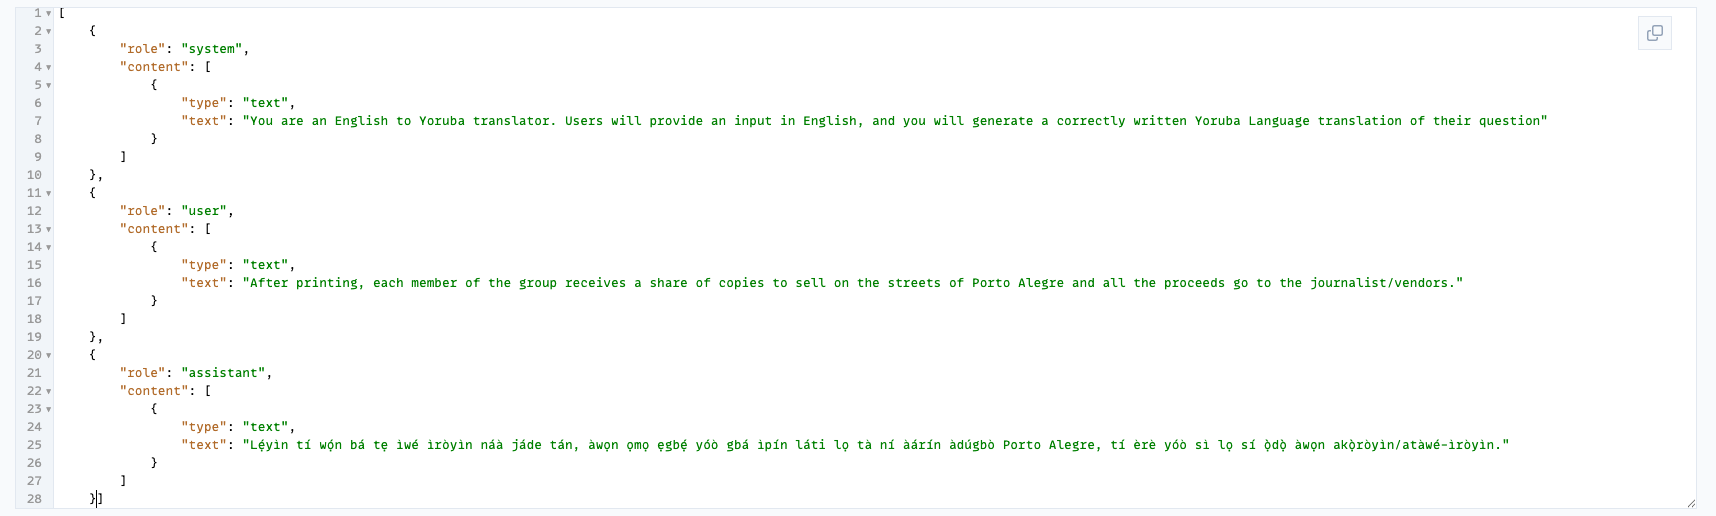

In [21]:
#Step 4: Apply tokenization to your datasets
# https://huggingface.co/docs/transformers/en/chat_templating (apply_chat_template)
def collate_fn(examples):
    texts = []
    
    for example in examples:
        # Apply chat template to the messages
        text = processor.apply_chat_template(
            example["messages"], 
            add_generation_prompt=False, 
            tokenize=False
        )
        texts.append(text.strip())

    # Tokenize the texts
    batch = processor(text=texts, return_tensors="pt", padding=True)
    
    # The labels are the input_ids
    labels = batch["input_ids"].clone()
    batch["labels"] = labels
    
    return batch

In [22]:
#Test Tokenization
collate_fn([dataset[345]])

{'input_ids': tensor([[     2,      2,    105,   2364,    107,  40414,    506,   2269,   5422,
           1816,    531, 135055,    753,  10522,    994,    506,  28700,   1816,
            532,   5017,   1663,    108,   6259,  16386, 236764,   1546,   4374,
            529,    506,   2299,  21500,    496,   4024,    529,  16258,    531,
           6739,    580,    506,  15729,    529,  45255, 165959,    532,    784,
            506,  24676,    817,    531,    506,  31484, 236786, 225768, 236761,
            106,    107,    105,   4368,    107, 236798, 238577, 238288, 236762,
          40178,  68982,    515, 237550,  80456, 132639,    494, 238577, 141622,
         236765, 236859, 141622, 236750, 237493, 236762,  40178,  26118, 236937,
          15119,    893, 170421, 236764,   1608, 236765,  18856,  59048, 236757,
         237550, 205396,  10204, 238577, 238288,    570, 236916, 237493,  86106,
         236898, 141622, 236758,   7893,  14759,   3916, 202196,    494, 236937,
          7424

In [23]:
#Step 5: Convert the list of dictionaries back to a Dataset object to pass into trainer
dataset_dict = {
    "messages": [sample["messages"] for sample in dataset]
}
hf_dataset = Dataset.from_dict(dataset_dict)

print(f"Dataset size: {len(hf_dataset)}")
print("Sample data structure:")
print(hf_dataset[0])

Dataset size: 10070
Sample data structure:
{'messages': [{'content': [{'text': 'Translate the following English text to Yoruba - Only return the translated text and nothing else', 'type': 'text'}], 'role': 'system'}, {'content': [{'text': 'Unit 1: What is Creative Commons?', 'type': 'text'}], 'role': 'user'}, {'content': [{'text': '\ufeffÌdá 1: Kín ni Creative Commons?', 'type': 'text'}], 'role': 'assistant'}]}


### Low Rank Matrices Adaption 

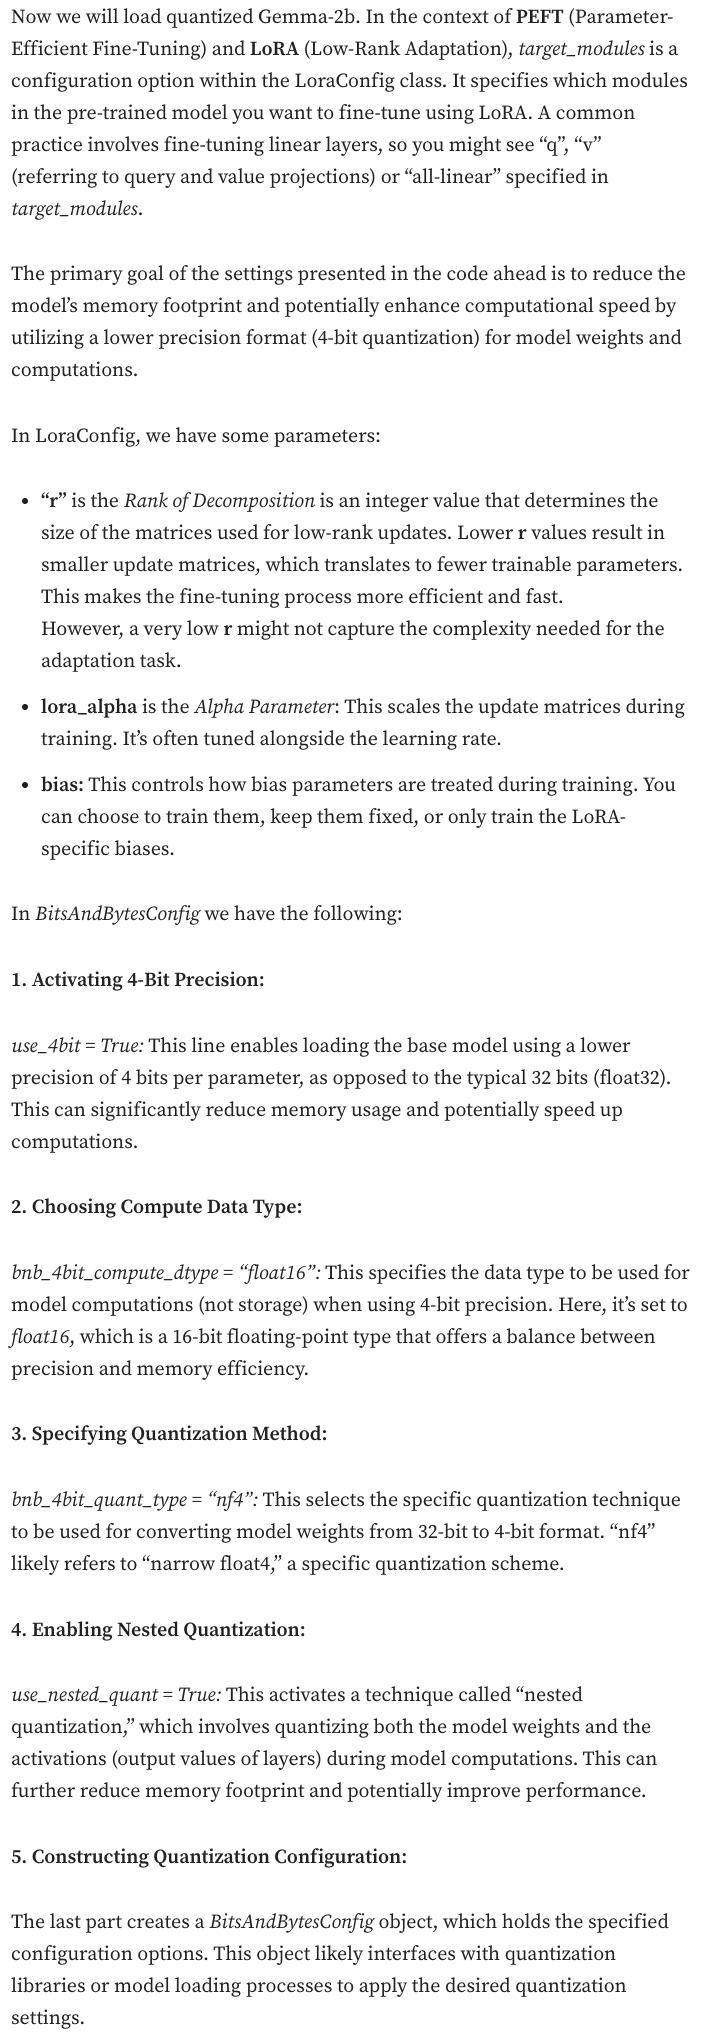


Credit : [LoraConfig - Fine Tuning Gemma-2b to Solve Math Problems
Rubens Zimbres](https://medium.com/google-developer-experts/fine-tuning-gemma-2b-to-solve-math-problems-ac4921ed531e)

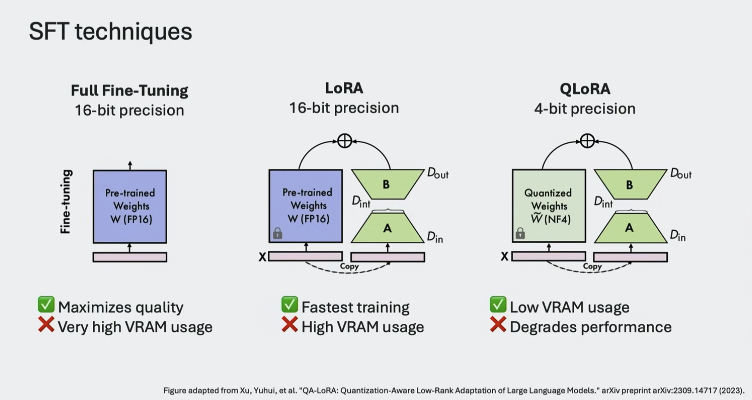

##### The SFTTrainer supports a built-in integration with peft, which makes it straightforward to efficiently tune LLMs using QLoRA. You only need to create a LoraConfig and provide it to the trainer.

In [24]:
# Step 6: Load your LORA and Quantization Configs
from peft import LoraConfig

# Check if GPU benefits from bfloat16
if torch.cuda.get_device_capability()[0] < 8:
    raise ValueError("GPU does not support bfloat16, please use a GPU that supports bfloat16.") 

# 3. Configure LoRA
peft_config = LoraConfig(
    r=8,                                           # LoRA attention dimension. Common values are 8, 16, 32, 64. Higher means more trainable parameters.
    lora_alpha=16,                                 # Scaling factor for LoRA. Typically 2*r.
    target_modules=["q_proj", "o_proj", "v_proj", "k_proj", "gate_proj", "up_proj", "down_proj"], # Modules to apply LoRA to. These are common for attention and feed-forward layers.
    lora_dropout=0.05,                             # Dropout probability for LoRA layers.
    bias="none",                                   # Do not apply LoRA to bias weights.
    task_type="CAUSAL_LM",                         # For language modeling tasks.
)

# Set up quantization config
#################################################################
# Configure 4-bit quantization (QLoRA)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                                      # Activate 4-bit precision base model loading
    bnb_4bit_quant_type="nf4",                              # Quantization type (fp4 or nf4)
    bnb_4bit_compute_dtype=torch.bfloat16,                  # Compute dtype for 4-bit base models
    bnb_4bit_use_double_quant=True,                         # Activate nested quantization for 4-bit base models (double quantization)
)

In [25]:
#Step 7: Apply Model Configs and Hardware (GPUs)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto" # Distributes model across available GPUs
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [26]:
# See how many parameters are trainable
model = get_peft_model(model, peft_config)
model.print_trainable_parameters() 

trainable params: 16,394,240 || all params: 4,316,473,712 || trainable%: 0.3798


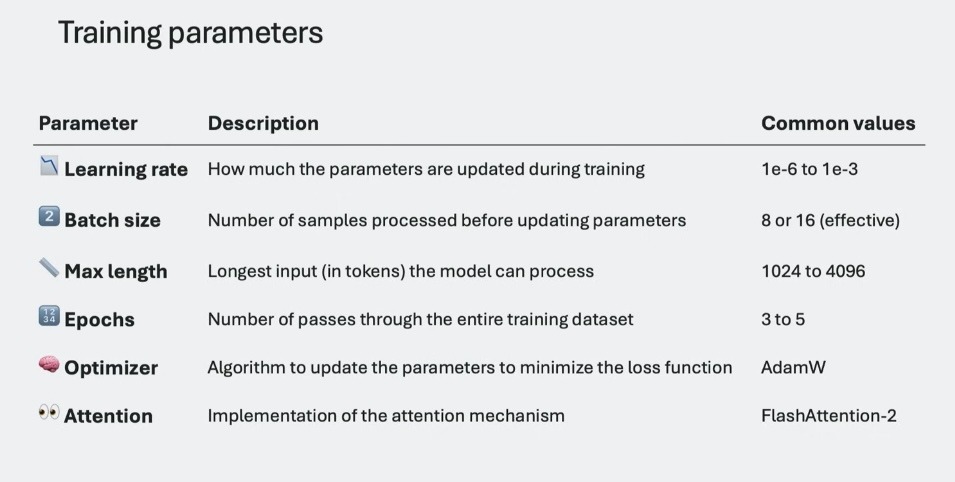

In [27]:
# Step 8: Define Training Arguments
from transformers import TrainingArguments
from trl import SFTTrainer, SFTConfig

args = SFTConfig(
    output_dir="./finetune_eng-to-yor-gemma-3b",# Where to save checkpoints
    num_train_epochs=1,                     # Number of training epochs
    per_device_train_batch_size=1,          # Batch size per GPU
    gradient_accumulation_steps=4,          # Accumulate gradients over 4 steps to simulate a batch size of 16 (4*4)
    save_strategy="epoch",                  # Save checkpoint after each epoch
    learning_rate=1e-4,                     # Learning rate for LoRA
    logging_steps=10,                       # Log every 10 steps
    optim="paged_adamw_8bit",               # Optimized AdamW for 8-bit quantization
    warmup_ratio=0.03,                      # Warmup ratio for learning rate
    dataset_text_field="messages",          # The field containing the formatted text
    max_seq_length=1024,
    fp16=True if torch.cuda.is_available() else False, # Use mixed precision if GPU is available
    push_to_hub=False,                      # Set to True if you want to push to Hugging Face Hub
)

In [28]:
# Step 9: Create and Train the SFTtrainer
trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=hf_dataset,
    peft_config=peft_config,
)

Tokenizing train dataset:   0%|          | 0/10070 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/10070 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
# Step 10: finetune using Gemma TRL and SFTtrainer - You only need to do this once
# Start training, the model will be automatically saved to the Hub and the output directory with trainer.save_model() if push_to_hub is set
trainer.train()

Step,Training Loss
10,0.000000
20,0.000000
30,0.000000
40,0.000000
50,0.000000
60,0.000000
70,0.000000
80,0.000000
90,0.000000
100,0.000000


In [ ]:
# free some memory
del model
del trainer
torch.cuda.empty_cache()

In [ ]:
# Inference
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig # Import BitsAndBytesConfig
from peft import PeftModel

model_id = "google/gemma-3-4b-it"
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Load base model with the quantization config
base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    torch_dtype=torch.bfloat16, 
    device_map="auto",
    trust_remote_code=True,
)

# Load LoRA adapters
lora_adapters_path = "./finetune_eng-to-yor-gemma-3b/checkpoint-2518"
try:
    # Now, PeftModel.from_pretrained will find the 4-bit quantized layers in base_model
    # and attach the adapters correctly.
    model = PeftModel.from_pretrained(base_model, lora_adapters_path)
    # model = base_model #for testing
    model.eval()
    print("LoRA adapters loaded successfully")
except Exception as e:
    print(f"Failed to load LoRA adapters: {e}")
    # Add a more informative message about why it's falling back to base_model
    print("Reverting to base_model. Generation might not be as good without LoRA.")
    model = base_model
    # You might want to re-raise the exception if you absolutely require LoRA to be loaded
    # raise

In [ ]:
# Prepare input
system_message = "Translate the following English text to Yoruba:"
input_text = "This is a beautiful day, full of sunshine."
sample = [
    {"role": "user", "content": f"{system_message}\n{input_text}"},]
# messages = [
#         {"role": "system", "content": [{"type": "text", "text": system_message}]},
#         {
#             "role": "user",
#             "content": [
#                 {"type": "text", "text": input_text},
#             ],
#         },
#     ]
def translate(messages, model, processor):
    # Convert sample into messages and then apply the chat template
    # Initialize a default return value
    output_text = "Error: Translation failed."
    # Apply chat template
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    # Tokenize the text
    inputs = processor(
        text=text,
        padding=True,
        return_tensors="pt",
    )

    # Get model device safely
    if hasattr(model, 'device'):
        model_device = model.device
    else:
        model_device = next(model.parameters()).device
    print(f"Model device: {model_device}")

    try:
        # Move inputs to device
        inputs = {k: v.to(model_device) for k, v in inputs.items()}
        print("Inputs moved to device successfully")

        # Generate with conservative settings
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=300,
                do_sample=True,
                temperature=0.7,
                top_p=0.9,
                pad_token_id=processor.tokenizer.eos_token_id,
                eos_token_id=processor.tokenizer.eos_token_id,
                use_cache=True,
            )
        
        # Extract and decode the generated part
        generated_ids = outputs[0][inputs["input_ids"].shape[-1]:]
        decoded_text = processor.decode(
            generated_ids,
            skip_special_tokens=True,
            clean_up_tokenization_spaces=True,
        )
        output_text = decoded_text.strip()

    except Exception as e:
        print(f"An error occurred during generation: {e}")
        # You can try a CPU fallback here if you wish, but for now we just report the error.
        
    finally:
        # Clean up GPU memory
        if torch.cuda.is_available():
            try:
                torch.cuda.empty_cache()
            except Exception as e_cache:
                print(f"Could not empty CUDA cache: {e_cache}")

    return output_text

In [ ]:
# generate the description
results = translate(sample, model, processor)
print(results)

In [ ]:
#Debugging
import torch
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.backends.cudnn.is_available())

In [ ]:
#Debugging - found this help while troubleshooting - make to install pytorch with the approach NVIDIA Drivers (Run nvidia-smi) before bnb
import torch
import transformers
import peft
import bitsandbytes
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1" # Keep this enabled for debugging

print("--- Environment Checks ---")
print(f"PyTorch Version: {torch.__version__}")
print(f"PyTorch CUDA Version: {torch.version.cuda}")
print(f"CUDA Available (PyTorch): {torch.cuda.is_available()}")
print(f"cuDNN Available (PyTorch): {torch.backends.cudnn.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Compute Capability: {torch.cuda.get_device_capability(0)}") # e.g., (8, 6) for RTX 30 series

print(f"Transformers Version: {transformers.__version__}")
print(f"PEFT Version: {peft.__version__}")
print(f"BitsAndBytes Version: {bitsandbytes.__version__}")

print("\n--- BitsAndBytes Check (Internal) ---")
try:
    print(bitsandbytes.COMPILED_WITH_CUDA_VERSION)
except AttributeError:
    print("bitsandbytes.COMPILED_WITH_CUDA_VERSION not found (older bnb version?)")

# Check bitsandbytes library path:
print(f"bitsandbytes path: {bitsandbytes.__file__}")
# This will show which exact .so/.dll it loaded.